# Import essential libraries and Read dataset


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from unidecode import unidecode
import re
import random
import ast

from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

restaurant info

In [2]:
restaurant= pd.read_csv('./data gathering/raw data.csv')
restaurant.sample(1)

,Unnamed: 0,name,score,review_num,label,address,link,page_info,rating,leat_shap,comment_number,comment_scores
14,14,آشپزخانه و غذای بیرون بر همیشه بهار,۳.۶,(۶۹ امتیاز),نوشیدنی شرکتی، نوشیدنی، خورشت,خیابان شهید نوری، خیابان غفاری ۷، آشپزخانه و غ...,/restaurant/menu/%D8%A2%D8%B4%D9%BE%D8%B2%D8%A...,[],"[<div class=""sc-dlfnbm Scores__RateBar-sc-q0gl...","۵۰,۰۰۰ تومان",۶,"['۴', '۵', '۳', '۲', '۵', '۵']"


restaurants menu

In [3]:
menu= pd.read_csv('./data gathering/menu.csv')
menu.sample()

,Unnamed: 0.1,Unnamed: 0,restaurant,category,food,price
86,86,86.0,فست فود زرین مشرق زمین,اضافات,سس سیر,"۴,۰۰۰ تومان"


# Data info and change type of columns if they need to be changed and rename certain columns as required


## 1. Get data info

In [4]:
restaurant.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      20 non-null     int64 
 1   name            20 non-null     object
 2   score           20 non-null     object
 3   review_num      15 non-null     object
 4   label           20 non-null     object
 5   address         20 non-null     object
 6   link            20 non-null     object
 7   page_info       20 non-null     object
 8   rating          20 non-null     object
 9   leat_shap       20 non-null     object
 10  comment_number  11 non-null     object
 11  comment_scores  20 non-null     object
dtypes: int64(1), object(11)
memory usage: 2.0+ KB


In [5]:
menu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 605 entries, 0 to 604
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0.1  605 non-null    int64  
 1   Unnamed: 0    593 non-null    float64
 2   restaurant    605 non-null    object 
 3   category      605 non-null    object 
 4   food          605 non-null    object 
 5   price         605 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 28.5+ KB


## 2. restructure data and change type of columns if they need to be changed

#### 2.1. restaurant

Drop unnecessary columns and rename certain columns as required

In [6]:
restaurant.rename(columns={'leat_shap':'min_purchase','score':'satisfaction_mean'},inplace=True)
restaurant.drop(columns=['Unnamed: 0','page_info'],inplace=True)

Rershape data as required

In [7]:
def clean_score(x):
    try:
        float_x = float(x)
        return float_x
    except ValueError:
        return np.nan
    
restaurant['satisfaction_mean'] = restaurant['satisfaction_mean'].apply(lambda x: clean_score(unidecode(str(x))))

In [8]:
restaurant['label']= restaurant['label'].apply(lambda data:data.split('، '))
restaurant['review_num']= restaurant['review_num'].apply(lambda data:np.nan if pd.isnull(data) else  int(unidecode(re.sub(r'\D', '', data))))
restaurant['min_purchase']= restaurant['min_purchase'].apply(lambda data:int(unidecode(re.sub(r'\D', '', data))))
restaurant['rating'] = restaurant['rating'].apply(lambda x: [int(match.group(1)) for match in re.finditer(r'value="(\d+)"', x)])
restaurant['satisfaction_rate']= restaurant['rating'].apply(lambda x: (x[0] + x[1]) )
restaurant['dissatisfaction_rate']= restaurant['rating'].apply(lambda x: (x[3] + x[4]) )
restaurant['comment_number']= restaurant['comment_number'].apply(lambda data:np.nan if pd.isnull(data) else  unidecode(data))

change data type

In [9]:
restaurant['name']= restaurant['name'].astype('string')
restaurant['review_num']= restaurant['review_num'].astype('Int32')
restaurant['address']= restaurant['address'].astype('string')
restaurant['comment_number']= restaurant['comment_number'].astype('Int32')


removing derived attribute and saving for sql

In [10]:
restaurants_sql_format_df= restaurant.drop(columns=['satisfaction_rate','dissatisfaction_rate','comment_number','comment_scores'])
restaurants_sql_format_df.to_csv('./sql/restaurants.csv')

#### 2.2. menu

In [11]:
menu=menu[menu['restaurant']!='کافه مکعب']

 Drop unnecessary columns 

In [12]:
menu.drop(columns=['Unnamed: 0'],inplace=True)

Rershape data as required

In [13]:
menu['price']= menu['price'].apply(lambda data:int(unidecode(re.sub(r'\D', '', data))))

change data type

In [14]:
menu['restaurant']= menu['restaurant'].astype('string')
menu['category']= menu['category'].astype('string')
menu['food']= menu['food'].astype('string')
menu['price']= menu['price'].astype('int64')


saving data for sql

In [15]:
menu.to_csv('./sql/menu.csv')

## 3. separate needed data for analyst

In [16]:
df= restaurant.iloc[1:]
df.drop(columns=['address','rating','label','link'],inplace=True)

In [17]:
filtered_menu= menu[(menu['category'] != 'نوشیدنی') & (menu['category'] != 'اضافات')]

In [18]:
filtered_menu = filtered_menu[~((filtered_menu['category'] == 'سالاد و پیش غذا') &
                       ((filtered_menu['restaurant'] == 'رستوران زنجیره ای مصطفی کلبادی نژاد') |
                        (filtered_menu['restaurant'] == 'رستوران گیلانی')))]
filtered_menu= filtered_menu.reset_index()

In [19]:
price= filtered_menu.groupby('restaurant')['price'].agg(['mean','min','max']).reset_index().rename(columns={})
price.columns = ['restaurant', 'price_mean', 'price_min', 'price_max']

category= menu.groupby(['restaurant','category']).size().reset_index()
Variety= category.groupby('restaurant').agg({'category':'count',0:'sum'}).reset_index().rename(columns={0:'product_num','category':'variety'})

In [20]:
df

,name,satisfaction_mean,review_num,min_purchase,comment_number,comment_scores,satisfaction_rate,dissatisfaction_rate
1,غذای بیرون بر سرو,3.8,45,50000,3,"['۵', '۵', '۲']",69,13
2,فست فود نوژان,4.2,162,85000,17,"['۵', '۵', '۵', '۳', '۲', '۵', '۳']",78,13
3,فست فود زرین مشرق زمین,4.1,714,45000,58,"['۲', '۴', '۵', '۳', '۴', '۵', '۵', '۳', '۵']",76,7
4,کباب بره صوفیا,NaN,<NA>,100000,<NA>,[],0,0
5,فست فود قارچ ویچ,NaN,5,125000,<NA>,[],20,80
6,خانه برگر,NaN,<NA>,100000,<NA>,[],0,0
7,مرغ شکم پرهمت,NaN,<NA>,60000,<NA>,[],0,0
8,رستوران ۹۰,NaN,<NA>,100000,<NA>,[],0,0
9,جعبه سوخاری,4.0,60,60000,4,[],78,12
10,بیرون بر خان,3.9,17,45000,2,"['۵', '۴']",71,0


In [21]:
df = df.merge(price, right_on='restaurant', left_on='name',how='left')
df = df.merge(Variety, right_on='restaurant', left_on='name', suffixes=('_variety', '_variety'),how='left')

In [22]:
result= restaurant['comment_scores'].apply(lambda data: pd.Series([int(unidecode(num)) for num in ast.literal_eval(data)]).value_counts()).fillna(0)
df= pd.concat([df,result],axis=1)

In [23]:
df[5]= df[5].astype(int)
df[4]= df[4].astype(int)
df[3]= df[3].astype(int)
df[2]= df[2].astype(int)

In [24]:
df.drop(columns={'restaurant_variety','comment_scores'},inplace=True)
df.rename(columns={'review_num':'site_score'},inplace=True)

In [25]:
df=df[df['name']!='کافه مکعب']

## 4. Replacing nan to zero

In [26]:
df["satisfaction_mean"].replace(np.nan, 0, inplace = True)
df["site_score"].replace(np.nan, 0, inplace = True)
df["comment_number"].replace(np.nan, 0, inplace = True)

## 5. Look at data info agian

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19 entries, 0 to 18
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   name                  19 non-null     string 
 1   satisfaction_mean     19 non-null     float64
 2   site_score            19 non-null     Int32  
 3   min_purchase          19 non-null     float64
 4   comment_number        19 non-null     Int32  
 5   satisfaction_rate     19 non-null     float64
 6   dissatisfaction_rate  19 non-null     float64
 7   price_mean            18 non-null     float64
 8   price_min             18 non-null     float64
 9   price_max             18 non-null     float64
 10  variety               19 non-null     float64
 11  product_num           19 non-null     float64
 12  5                     19 non-null     int32  
 13  2                     19 non-null     int32  
 14  3                     19 non-null     int32  
 15  4                     19 non-n

# Missing and Null values


In [28]:
df.describe()



,satisfaction_mean,site_score,min_purchase,comment_number,satisfaction_rate,dissatisfaction_rate,price_mean,price_min,price_max,variety,product_num,5,2,3,4
count,19.000000,19.0,19.000000,19.0,19.000000,19.000000,18.000000,18.000000,1.800000e+01,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000
mean,2.600000,65.473684,88578.947368,5.842105,53.315789,12.315789,179367.173496,70388.888889,3.891667e+05,5.421053,30.631579,1.315789,0.210526,0.263158,0.526316
std,2.067204,161.814492,41886.507758,13.288521,36.772654,19.522217,69606.500281,57380.196306,2.979598e+05,2.652374,20.363940,1.600439,0.418854,0.653376,1.020263
min,0.000000,0.0,45000.000000,0.0,0.000000,0.000000,71050.000000,10000.000000,1.400000e+05,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.5,55000.000000,0.0,10.000000,0.000000,122040.000000,45500.000000,2.242500e+05,4.000000,18.500000,0.000000,0.000000,0.000000,0.000000
50%,3.800000,17.0,85000.000000,2.0,69.000000,6.000000,177255.303030,60000.000000,3.150000e+05,5.000000,27.000000,0.000000,0.000000,0.000000,0.000000
75%,4.150000,48.0,100000.000000,5.0,78.000000,16.000000,228288.043478,67750.000000,3.792500e+05,7.000000,36.500000,2.500000,0.000000,0.000000,1.000000
max,5.000000,714.0,203000.000000,58.0,100.000000,80.000000,307358.108108,250000.000000,1.370000e+06,11.000000,88.000000,4.000000,1.000000,2.000000,4.000000


In [29]:
df[df['price_mean'].isna() ]

,name,satisfaction_mean,site_score,min_purchase,comment_number,satisfaction_rate,dissatisfaction_rate,price_mean,price_min,price_max,variety,product_num,5,2,3,4
4,فست فود قارچ ویچ,0.0,5,125000.0,0,20.0,80.0,NaN,NaN,NaN,1.0,11.0,0,0,0,0


In [30]:
df=df[df['name']!='فست فود قارچ ویچ']

**Note**: the zero value or nan exist for new restaurant are scores related or comment columns they are **not missing** just not exist yet

# Outliers

### Setting some functioons


In [31]:
def outlier_diff(df,li):
    for col in df.columns[li]:
        Q1 , Q3 = df[col].quantile(.25) , df[col].quantile(.75)
        IQR = Q3 - Q1

        min_val = Q1 - (IQR*1.5)
        max_val = Q3 + (IQR*1.5)


        lower_limit = abs(min_val) / (abs(min_val) + abs(max_val))
        upper_limit = abs(max_val) / (abs(min_val) + abs(max_val))

        print("{} :\toutliers count : {} \tpercentage : {}".format (col,
            len((np.where((df[col] > max_val) | (df[col] < min_val))[0])),
            len((np.where((df[col] > max_val) | (df[col] < min_val))[0]))*100/df.shape[0]))

In [32]:
sns.set_theme(style='darkgrid')
def generate_random_color():
    return "#{:02x}{:02x}{:02x}".format(random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))

In [33]:
def box_plot(df, columns ):
    colors = [generate_random_color() for _ in range(len(columns))]
    fig , ax = plt.subplots(1,len(columns),figsize=(18, 7))

    for i in range(len(columns)):
        sns.boxplot(data=df, y=df.columns[columns[i]], color=colors[i] , ax=ax[i])
        
    plt.tight_layout() 
    plt.show()

In [34]:
def heatmap(corr_matrix,color,text):
    fig, ax = plt.subplots(figsize=(14, 6))
    sns.heatmap(corr_matrix, annot=True, cmap=color, linewidths=0.5, ax=ax)

    ax.set_title(text, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45,  fontsize=12)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
    
    plt.show()

### Finding outlier

In [35]:
outlier_diff(df,[i for i in range(1,16)])

satisfaction_mean :	outliers count : 0 	percentage : 0.0
site_score :	outliers count : 2 	percentage : 11.11111111111111
min_purchase :	outliers count : 1 	percentage : 5.555555555555555
comment_number :	outliers count : 2 	percentage : 11.11111111111111
satisfaction_rate :	outliers count : 0 	percentage : 0.0
dissatisfaction_rate :	outliers count : 1 	percentage : 5.555555555555555
price_mean :	outliers count : 0 	percentage : 0.0
price_min :	outliers count : 4 	percentage : 22.22222222222222
price_max :	outliers count : 2 	percentage : 11.11111111111111
variety :	outliers count : 0 	percentage : 0.0
product_num :	outliers count : 2 	percentage : 11.11111111111111
5 :	outliers count : 0 	percentage : 0.0
2 :	outliers count : 4 	percentage : 22.22222222222222
3 :	outliers count : 3 	percentage : 16.666666666666668
4 :	outliers count : 1 	percentage : 5.555555555555555


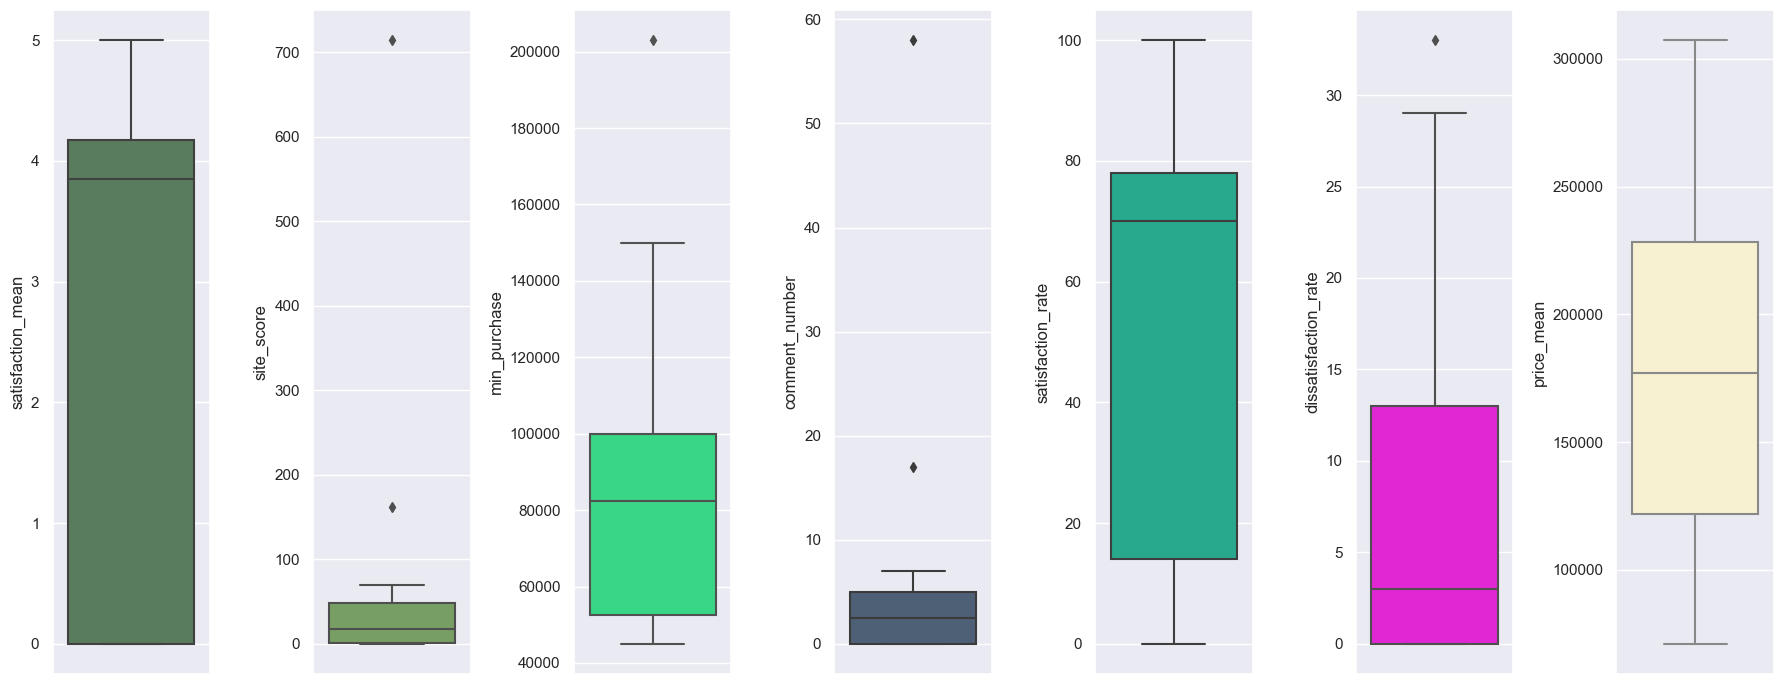

In [36]:
box_plot(df, [i for i in range(1,8)])

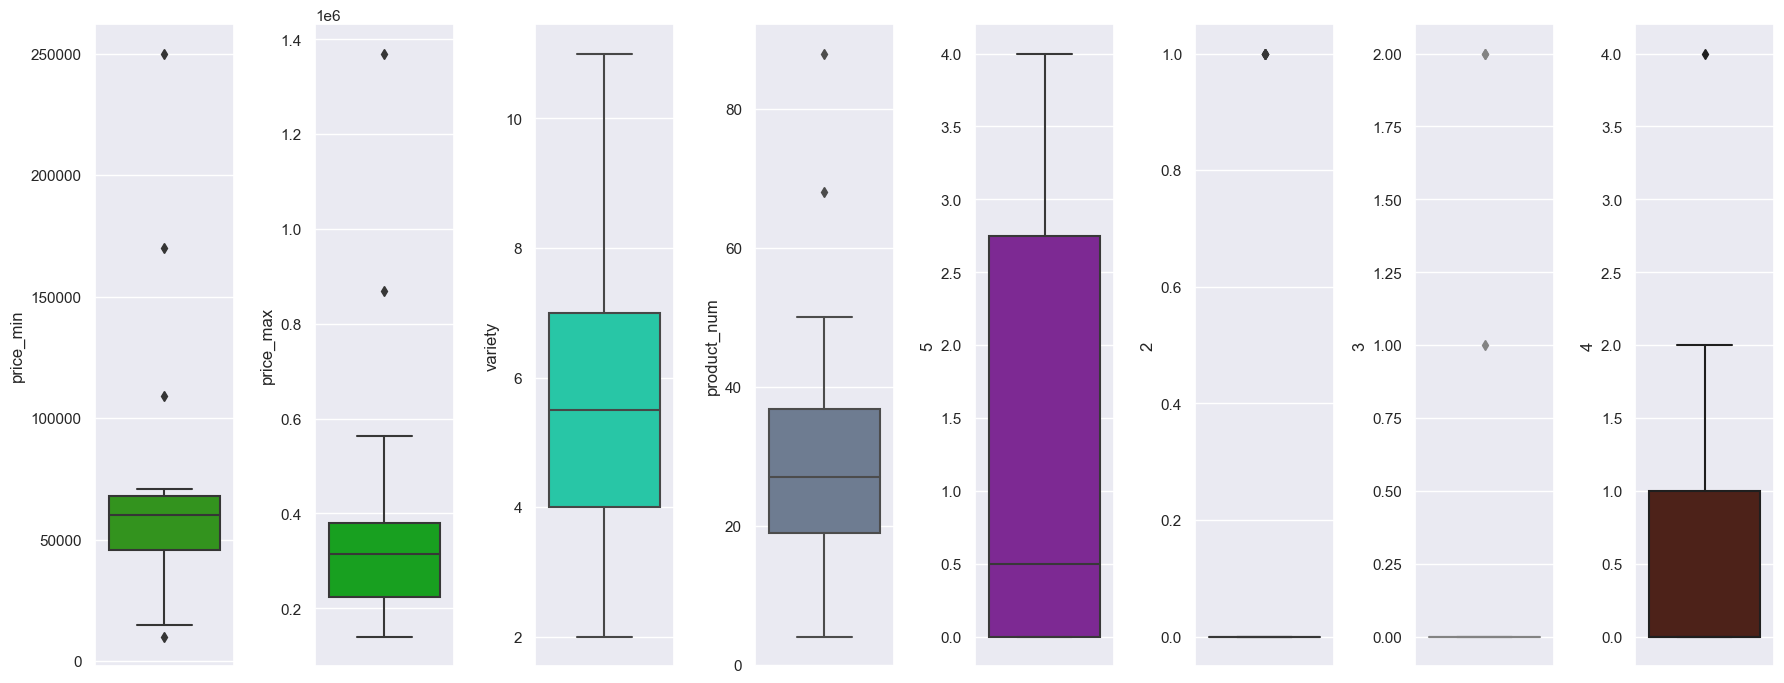

In [37]:
box_plot(df, [i for i in range(8,16)])

### Draw heatmap

there is interesting relation between some columns

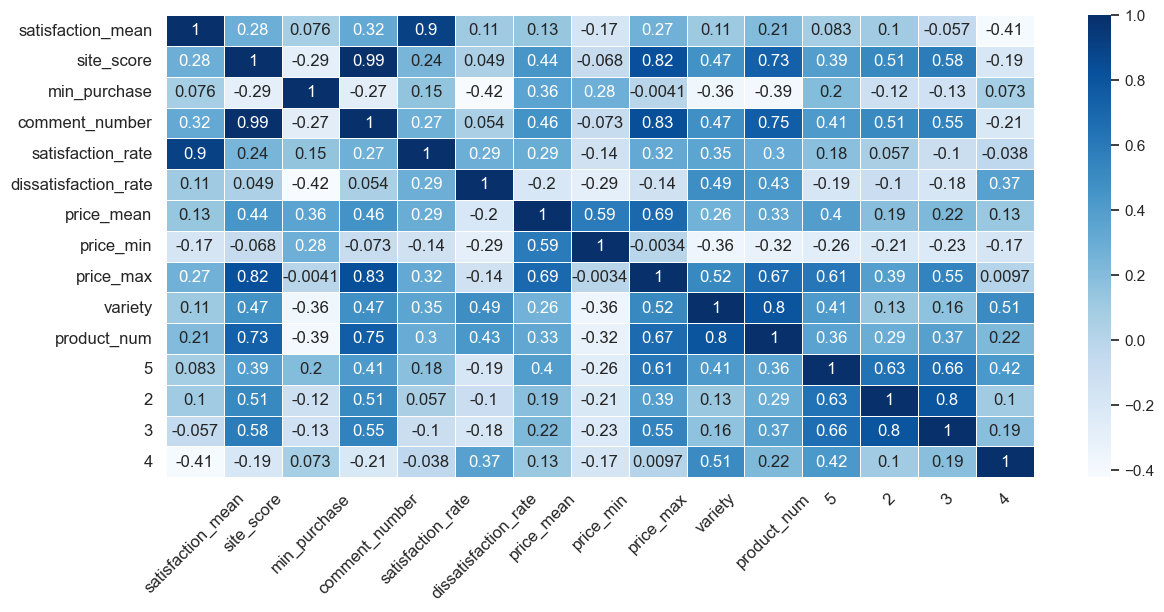

In [38]:
correlation_matrix = df[df.columns[[i for i in range(1,16)]]].corr()

heatmap(correlation_matrix,'Blues','')

# Calculating KPIs

we defind below KPIs:

- satisfaction mean
- site score
- satisfaction rate
- customer satisfaction score (CSAT)  
- customer dissatisfaction score (CDSAT)
- comment satisfaction score (CSC)
- comment dissatisfaction score (CDCS)
- food variety 
- min purchase score
- price mean score
- price max score
- price_min_score

In [39]:
kpis_df= df[['name','satisfaction_mean','site_score','satisfaction_rate','dissatisfaction_rate']]
kpis_df.rename(columns={'satisfaction_rate':'csat','dissatisfaction_rate':'cdsat'},inplace=True)

In [40]:
kpis_df['csc']=( (df[5]+df[4]) / (df[5]+df[4]+df[3]+df[2])).replace(np.nan,0)
kpis_df['cdcs']= ((df[2]+df[3]) / (df[5]+df[4]+df[3]+df[2])).replace(np.nan,0)
kpis_df['variety']= df['variety']

In [41]:
scaler= MinMaxScaler()

kpis_df['min_purchase_score'] = 1 - scaler.fit_transform(df[['min_purchase']])
kpis_df['price_mean_score'] = 1 - scaler.fit_transform(df[['price_mean']])
kpis_df['price_max_score'] = 1 - scaler.fit_transform(df[['price_max']])
kpis_df['price_min_score'] = 1 - scaler.fit_transform(df[['price_min']])

kpis_df['cdsat']= 1 - scaler.fit_transform(kpis_df[['cdsat']])
kpis_df['cdcs']= 1 - scaler.fit_transform(kpis_df[['cdcs']])

In [42]:
kpis_df['satisfaction_mean']= scaler.fit_transform(kpis_df[['satisfaction_mean']])
kpis_df['site_score']= scaler.fit_transform(kpis_df[['site_score']])
kpis_df['csat']= scaler.fit_transform(kpis_df[['csat']])
kpis_df['variety']= scaler.fit_transform(kpis_df[['variety']])

# Calculating scores and classification

The calculated score is mostly based on **people's feedback**.  
The score can be changed with different insights and what **measure** are most important to the **company**

In [43]:
kpis_df['score']= ( 
        0 * kpis_df['satisfaction_mean'] + 0 * kpis_df['site_score'] + 18 * kpis_df['csat'] +
        18 * kpis_df['cdsat'] + 9 * kpis_df['csc'] + 9 *kpis_df['cdcs'] + 4.5 * kpis_df['variety'] + 
        1.5 * kpis_df['min_purchase_score'] + 4 * kpis_df['price_mean_score'] +
        2 * kpis_df['price_min_score'] + 1 * kpis_df['price_max_score'] 
    )

In [44]:
kpis_df['score']= scaler.fit_transform(kpis_df[['score']])

In [45]:
labels= ['E','D','C','B','A']
bins=[0,0.2,0.4,0.6,0.8,1]
kpis_df['category'] = pd.cut(kpis_df['score'], bins=bins, labels=labels, include_lowest=True)

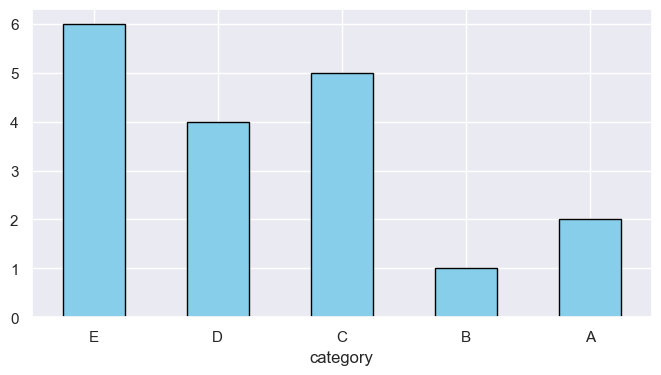

In [46]:
grouped_data= kpis_df.groupby('category').size()
plt.figure(figsize=(8, 4))
grouped_data.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xticks(rotation=0)
plt.show()

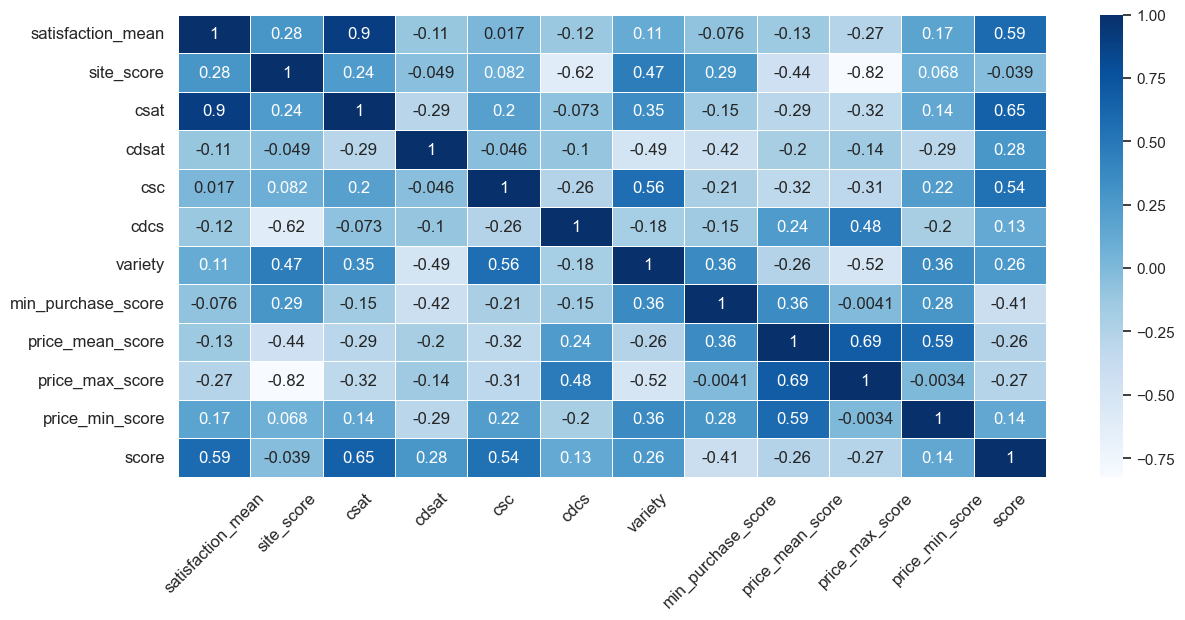

In [47]:
correlation_matrix = kpis_df[kpis_df.columns[[i for i in range(1,kpis_df.shape[1]-1) ]]].corr()
heatmap(correlation_matrix,'Blues','')

In [48]:
kpis_df.to_excel('./data/KPIs.xlsx')
df.to_excel('./data/data.xlsx')